In [8]:
#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/?unapproved=601592&moderation-hash=d98f616a2939421833382d1e7772df57#comment-601592
import os
import pandas as pd
from matplotlib import pyplot
import numpy as np
from scipy.stats import uniform, randint
from sklearn.datasets import load_breast_cancer, load_diabetes, load_wine
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot

[21:30:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
0.2401475171547707


In [ ]:
def display_scores(scores):
    print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

def report_best_scores(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]

# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]

# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [ ]:
# load the dataset
series = read_csv('Rossmann_Store1_Data_FULL.csv', header=0, index_col=0)
values = series.values
# transform the time series data into supervised learning
data = series_to_supervised(values, n_in=585)

>expected=6206.0, predicted=5376.8
>expected=6816.0, predicted=5336.3
>expected=6574.0, predicted=5361.9
>expected=6709.0, predicted=5560.6
>expected=4163.0, predicted=6254.7
>expected=4194.0, predicted=4633.2
>expected=3467.0, predicted=4386.0
>expected=3549.0, predicted=3945.7
>expected=4173.0, predicted=3898.7
>expected=5377.0, predicted=4407.4
>expected=4648.0, predicted=5724.8
>expected=4110.0, predicted=5036.8
>expected=4116.0, predicted=4234.3
>expected=4718.0, predicted=4502.0
>expected=4594.0, predicted=4888.7
>expected=3722.0, predicted=4520.5
>expected=3037.0, predicted=4450.8
>expected=3319.0, predicted=4113.0
>expected=3076.0, predicted=3500.9
>expected=3198.0, predicted=3402.4
>expected=4318.0, predicted=3267.9
>expected=5575.0, predicted=5625.6
>expected=5199.0, predicted=5751.7
>expected=5775.0, predicted=4991.7
>expected=6228.0, predicted=5017.1
>expected=5850.0, predicted=5493.9
>expected=5591.0, predicted=5753.4
>expected=4564.0, predicted=5386.7
>expected=4960.0, pr

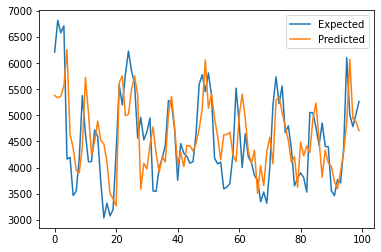

In [21]:
# evaluate
mae, y, yhat = walk_forward_validation(data, 100)
print('MAE: %.3f' % mae)
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

In [28]:
out = np.array(yhat, dtype=int)
out.round()
print(out)
df = pd.DataFrame({'Predicted Sales': out})
df.to_csv(r'C:\Users\gurpr\Videos\BetaSci\Xgboost_pred100.csv', index=False, header=True)

[5376 5336 5361 5560 6254 4633 4386 3945 3898 4407 5724 5036 4234 4501
 4888 4520 4450 4113 3500 3402 3267 5625 5751 4991 5017 5493 5753 5386
 3586 4079 3973 4434 4778 4267 3910 4207 4107 5020 5360 4775 4062 4291
 4019 4416 4418 4314 4467 4737 5126 6057 5133 5412 4941 4603 4148 4626
 4632 4675 4242 4109 4985 5401 4929 4307 4080 4330 3506 4033 3653 4299
 4577 4071 5288 5346 5055 4787 4518 4099 4210 3622 4488 4223 4413 4284
 4934 5233 4524 3813 4330 4091 4019 3730 3597 3924 4297 4858 6065 4935
 4877 4703]
